In [1]:
# use kernel version 3.11.0
import numpy as np
from numpy import asarray
import os
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, Dense
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import color

In [2]:
dir_path = 'C:/Users/prasa/Downloads/TB_Chest_Radiography_Database/'

In [3]:
def numpize(subset: str, img_size=(128, 128), grayscale=False):
    """
    Convert a set of images from a specified subset to NumPy arrays.
    Parameters:
    - subset (str): Specifies the subset of images, e.g., 'Normal' or 'Tuberculosis'.
    - img_size (tuple): Tuple representing the desired size of the images after resizing.
    - grayscale (bool): If True, convert images to grayscale.
    Returns:
    - numpy_array (numpy.ndarray): NumPy array containing the transformed images.
    """
    image_dir = f'{dir_path}/{subset}/'
    image_files = os.listdir(image_dir)
    image_count = len(image_files)
    transformed_images = []

    for i in tqdm(range(1, image_count + 1), desc='Transforming...'):
        image_path = f'{image_dir}/{subset}-{i}.png'
        image = Image.open(image_path)

        # Ensure all images are in the same format
        if grayscale:
            image = image.convert('L')  # Convert to grayscale
        else:
            image = image.convert('RGB')  # Convert to RGB

        # Resize all images to the specified size without padding
        resized_image = image.resize(img_size)
        data = np.asarray(resized_image)
        transformed_images.append(data)

    numpy_array = np.array(transformed_images)
    return numpy_array

norm = numpize(subset='Normal', 
               img_size=(128, 128), 
               grayscale=False)
norm.shape

Transforming...: 100%|██████████| 3500/3500 [02:01<00:00, 28.73it/s]


(3500, 128, 128, 3)

In [5]:
tb = numpize(subset='Tuberculosis', 
             img_size=(128, 128), 
             grayscale=False)
tb.shape
target_norm = np.zeros(norm.shape[0])
print(f'Shape: {target_norm.shape[0]}, array: {target_norm}')

Transforming...: 100%|██████████| 700/700 [00:10<00:00, 67.14it/s] 

Shape: 3500, array: [0. 0. 0. ... 0. 0. 0.]


In [6]:
def show_image(images, target, title, num_display=16, num_cols=4, cmap='gray', random_mode=False):
    '''
    :Parameters
        images (ndarray (n,)): Input data as a numpy array.
        target (ndarray (n,)): Target data as a numpy array.
        title (String): Title of the plot.
        num_display (int): Number of images to display. Default is 16.
        num_cols (int): Number of columns in the plot. Default is 4.
        cmap (str): Color map for displaying images. Default is 'gray'.
        random_mode (bool): If True, display images randomly. If False, display the first num_display images. Default is False.
    '''
    # Determine the number of rows based on the num_cols parameter
    n_cols = min(num_cols, num_display)
    n_rows = int(np.ceil(num_display / n_cols))

    n_images = min(num_display, len(images))
    if random_mode:
        random_indices = np.random.choice(
            len(images), num_display, replace=False)
    else:
        random_indices = np.arange(num_display)

    fig, axes = plt.subplots(
        nrows=n_rows, ncols=n_cols, figsize=(20, 4*n_rows))
    for i, ax in enumerate(axes.flatten()):
        if i >= n_images:  # Check if the index exceeds the available number of images
            break
        # Incase (Did PCA)
        index = random_indices[i]
        if len(images.shape) == 2:
            image = images[index].reshape((128, 128)).astype(int)
        else:
            image = images[index]

        ax.imshow(image, cmap=cmap)
        ax.set_title("Target: {}".format(target[index]))

        # Add image index as text
        ax.text(0.5, -0.15, f'Image Index: {index}', transform=ax.transAxes,
                fontsize=10, ha='center')

    plt.suptitle(f"{title} (Displaying {num_display} Images)",
                 fontsize=16, fontweight='bold')

    fig.set_facecolor('white')
    plt.tight_layout() 
    plt.show()

In [7]:
from skimage import img_as_float
from skimage import exposure
def plot_gray_scale_histogram(images, titles, bins=100):
    '''
    Plot Gray Scale Histograms of Images.

    Parameters:
        - images (list): List of grayscale images to plot histograms for.
        - titles (list): List of titles for each histogram.
        - bins (int, optional): Number of bins for the histogram. Default is 100.

    Returns:
        None

    This function generates histograms for a list of grayscale images and displays them side by side. Each histogram is accompanied by its respective title.

    The function does not return any values; it displays the histogram plots directly.
    '''
    # Display results
    fig, axes = plt.subplots(2, len(images), figsize=(20, 8))

    for i, (title, image) in enumerate(zip(titles, images)):
        ax_img, ax_hist, ax_cdf, random_index = img_and_hist(
            image, axes[:, i], bins)

        mean_value = np.mean(image)
        std_value = np.std(image)
        min_value = np.min(image)
        max_value = np.max(image)

        ax_img.set_title('Random image of '+r'$\bf{' + f'{title}'+'}$' +
                         f'\nMean: {mean_value: .2f}, Std: {std_value: .2f}, Min: {min_value: .2f}, Max: {max_value: .2f}', fontsize=16)
        ax_img.text(0.5, -0.15, f'Image Index: {random_index}\n(Display random image)', transform=ax_img.transAxes,
                    fontsize=10, ha='center')

        y_min, y_max = ax_hist.get_ylim()
        ax_hist.set_title(
            'Distribution of pixel intensities of'+r'$\bf{' + f'{title}'+'}$', fontsize=16)
        ax_hist.set_ylabel('Number of pixels')
        ax_hist.set_yticks(np.linspace(0, y_max, 5))

        ax_cdf.set_ylabel('Fraction of total intensity')
        ax_cdf.set_yticks(np.linspace(0, 1, 5))

    plt.suptitle('Gray scale Histogram: Distribution of intensity pixel',
                 fontsize=16, fontweight='bold')
    # Prevent overlap of y-axis labels
    fig.tight_layout()
    plt.savefig('explation_purpose.png', bbox_inches='tight')

    plt.show()


def img_and_hist(image_data, axes, bins=100):
    '''
    Plot an image along with its histogram and cumulative histogram.

    Parameters:
        - image_data (ndarray): Grayscale image data as a numpy array.
        - axes (list): List of axes for displaying the image, histogram, and cumulative histogram.
        - bins (int): Number of bins for the histogram.

    Returns:
        - ax_img, ax_hist, ax_cdf: Axes objects for image, histogram, and cumulative histogram.

    This function displays an image along with its histogram and cumulative histogram. It takes the grayscale image data, a list of axes for plotting, and the number of bins for the histogram.

    The function returns the axes objects for the image, histogram, and cumulative histogram.
    '''

    '''
    Plot an image along with its histogram and cumulative histogram.
    '''
    image = img_as_float(image_data)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    random_index = np.random.randint(0, len(image_data))

    # Display image
    ax_img.imshow(image if image.shape[0] ==1 else image[random_index], cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    # ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf, random_index

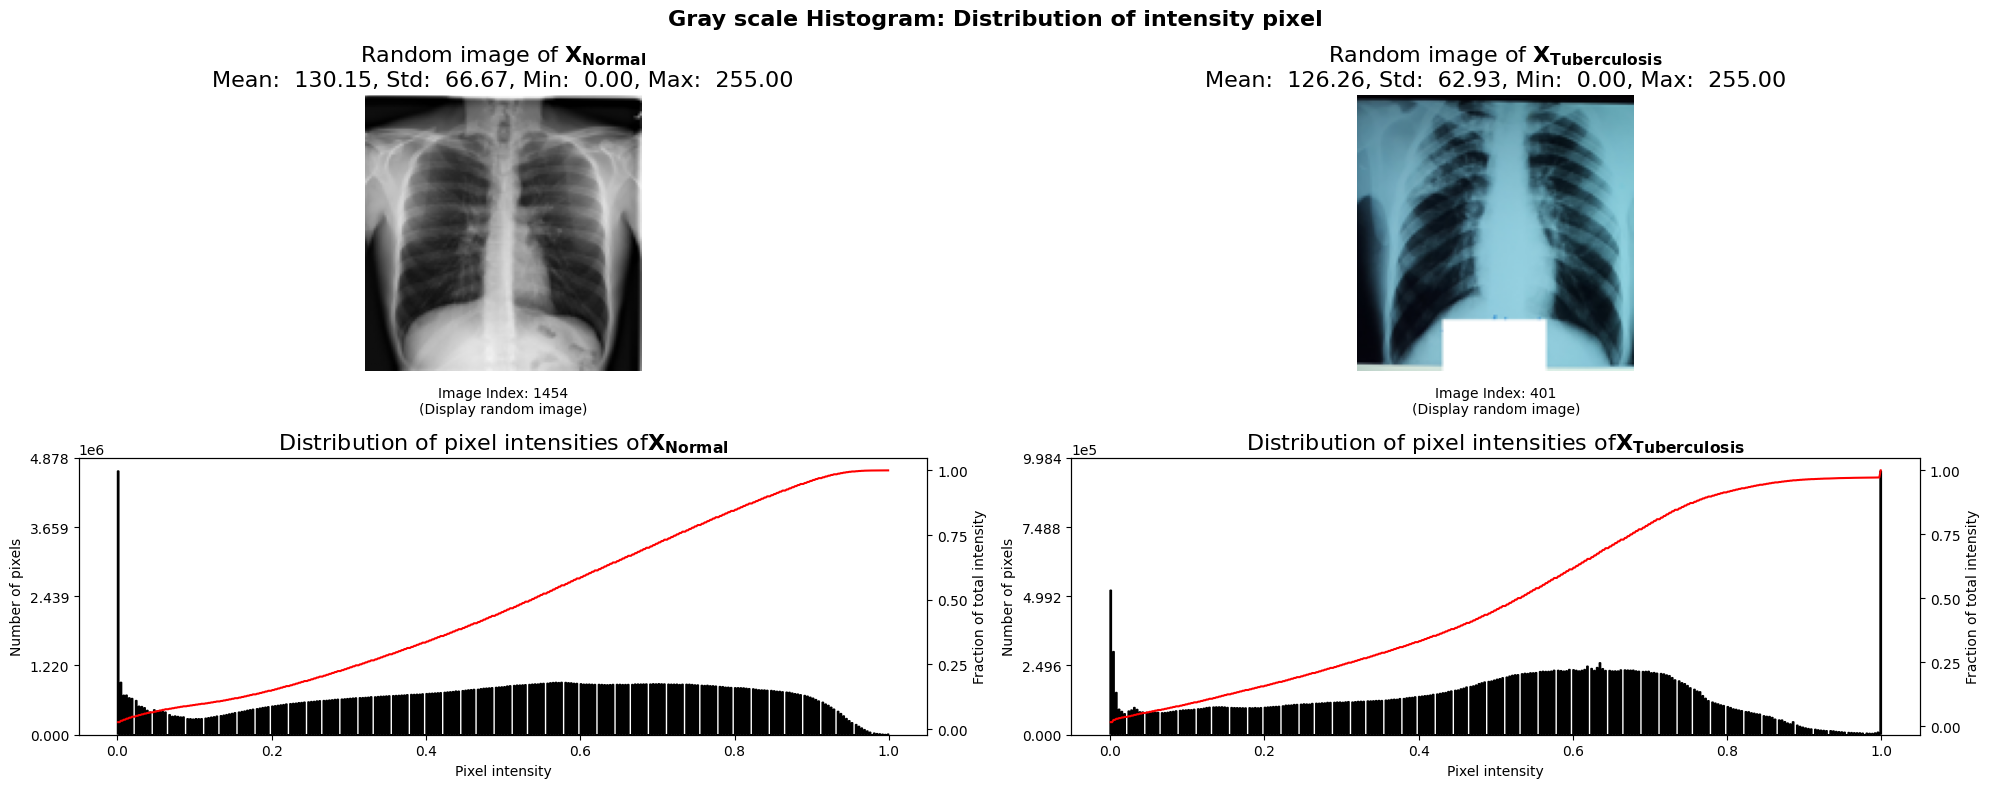

In [8]:
images = [norm, tb]
subsets = ['X_{Normal}', 'X_{Tuberculosis}']
# For visualization

plot_gray_scale_histogram(images=images, titles=subsets, bins=555)

In [9]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("trainedmodel.h5")



In [10]:
from tensorflow.keras.preprocessing import image
import numpy as np



# Load an example image for prediction
img_path = "C:/Users/prasa/Downloads/TB_Chest_Radiography_Database/Normal/Normal-75.png"
img = image.load_img(img_path, target_size=(128, 128))  # Adjust the target size based on your model's input shape
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image

# Make a prediction
prediction = model.predict(img_array)
print(prediction)

# Print the prediction result
if prediction[0] >=0.7:
    print("Tuberculosis")
else:
    print("Normal")


1/1 [==============================] - 0s 334ms/step
[[0.00079305]]
Normal


In [11]:

import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

def x_ray_image_augmentation(images, targets, sample_count):
    # Randomize the data augmentation parameters
    rotation_range = random.randint(-5, 5)
    zoom_range = random.uniform(0.0, 0.1)
    fill_mode = random.choice(['nearest', 'constant', 'wrap'])

    # Create the ImageDataGenerator with randomized parameters
    datagen = ImageDataGenerator(
        rotation_range=rotation_range,
        zoom_range=zoom_range,
        fill_mode=fill_mode
    )

    # Load and augment the data
    augmented_data_generator = datagen.flow(images, targets, batch_size=1)

    combined_images = []
    combined_labels = []

    for _ in tqdm(range(sample_count), desc='augmenting...'):
        batch_images, batch_labels = augmented_data_generator.next()
        combined_images.append(batch_images)
        combined_labels.append(batch_labels)

    combined_images = np.concatenate(combined_images, axis=0)
    combined_labels = np.concatenate(combined_labels, axis=0)

    # Save the augmented data
    np.save("tb_augmented.npy", combined_images)
    np.save("target_tb_augmented.npy", combined_labels)

    return combined_images, combined_labels

# Scaled the dataset before do Augmentation 
norm = norm/255
tb = tb/255

# Assuming you have 'tb' and 'target_tb' defined
target_tb = np.ones(tb.shape[0])
tb_augmented, target_tb_augmented = x_ray_image_augmentation(images=tb, targets=target_tb, sample_count=2800)

# def x_ray_image_augmentation(images, targets, sample_count):
#     '''
#     :Parameters
#         df (ndarray (n,)): Input data as a numpy array.
#         target (ndarray (n,)): Target data as a numpy array.
#         sample_count (integer64): Number of data needed.
#     '''

#     # Randomize the data augmentation parameters
#     rotation_range = random.randint(-5, 5)
#     # width_shift_range = random.uniform(0.0, 0.05)      Not reccomend
#     # height_shift_range = random.uniform(0.0, 0.05)     Not reccomend
#     # shear_range = random.uniform(0.0, 0.1)             Not reccomend
#     zoom_range = random.uniform(0.0, 0.1)
#     fill_mode = random.choice(['nearest',
#                                'constant',
#                                #    'reflect',               Not reccomend
#                                'wrap'])

#     # Create the ImageDataGenerator with randomized parameters
#     datagen = ImageDataGenerator(
#         rotation_range=rotation_range,
#         # width_shift_range=width_shift_range,             Not reccomend
#         # height_shift_range=height_shift_range,           Not reccomend
#         # shear_range=shear_range,                         Not reccomend
#         zoom_range=zoom_range,
#         fill_mode=fill_mode
#     )
#     # Load and augment the data

#     augmented_data_generator = datagen.flow(images, targets, batch_size=1)
#     batch_images, batch_labels = augmented_data_generator.next()
#     for _ in tqdm(range(sample_count), desc='augmenting...'):
#         batch_images, batch_labels = augmented_data_generator.next()
#         try:
#             combined_images = np.concatenate(
#                 (combined_images, batch_images), axis=0)
#             combined_labels = np.concatenate(
#                 (combined_labels, batch_labels), axis=0)
#         except NameError:
#             combined_images = np.concatenate((images, batch_images), axis=0)
#             combined_labels = np.concatenate((targets, batch_labels), axis=0)
#     '''
#     Returns:
#         combined_images (ndarray (n,)) : generated images
#         combined_labels (ndarray (n,)) : generated labels
#     '''

#     return combined_images, combined_labels


augmenting...: 100%|██████████| 2800/2800 [00:13<00:00, 205.66it/s]


In [13]:
def show_image(images, target, title, num_display=16, num_cols=4, cmap='gray', random_mode=False):
    '''
    :Parameters
        images (ndarray (n,)): Input data as a numpy array.
        target (ndarray (n,)): Target data as a numpy array.
        title (String): Title of the plot.
        num_display (int): Number of images to display. Default is 16.
        num_cols (int): Number of columns in the plot. Default is 4.
        cmap (str): Color map for displaying images. Default is 'gray'.
        random_mode (bool): If True, display images randomly. If False, display the first num_display images. Default is False.
    '''
    # Determine the number of rows based on the num_cols parameter
    n_cols = min(num_cols, num_display)
    n_rows = int(np.ceil(num_display / n_cols))

    n_images = min(num_display, len(images))
    if random_mode:
        random_indices = np.random.choice(
            len(images), num_display, replace=False)
    else:
        random_indices = np.arange(num_display)

    fig, axes = plt.subplots(
        nrows=n_rows, ncols=n_cols, figsize=(20, 4*n_rows))
    for i, ax in enumerate(axes.flatten()):
        if i >= n_images:  # Check if the index exceeds the available number of images
            break
        # Incase (Did PCA)
        index = random_indices[i]
        if len(images.shape) == 2:
            image = images[index].reshape((128, 128)).astype(int)
        else:
            image = images[index]

        ax.imshow(image, cmap=cmap)
        ax.set_title("Target: {}".format(target[index]))

        # Add image index as text
        ax.text(0.5, -0.15, f'Image Index: {index}', transform=ax.transAxes,
                fontsize=10, ha='center')

    plt.suptitle(f"{title} (Displaying {num_display} Images)",
                 fontsize=16, fontweight='bold')

    fig.set_facecolor('white')
    plt.tight_layout() 
    return plt.show()

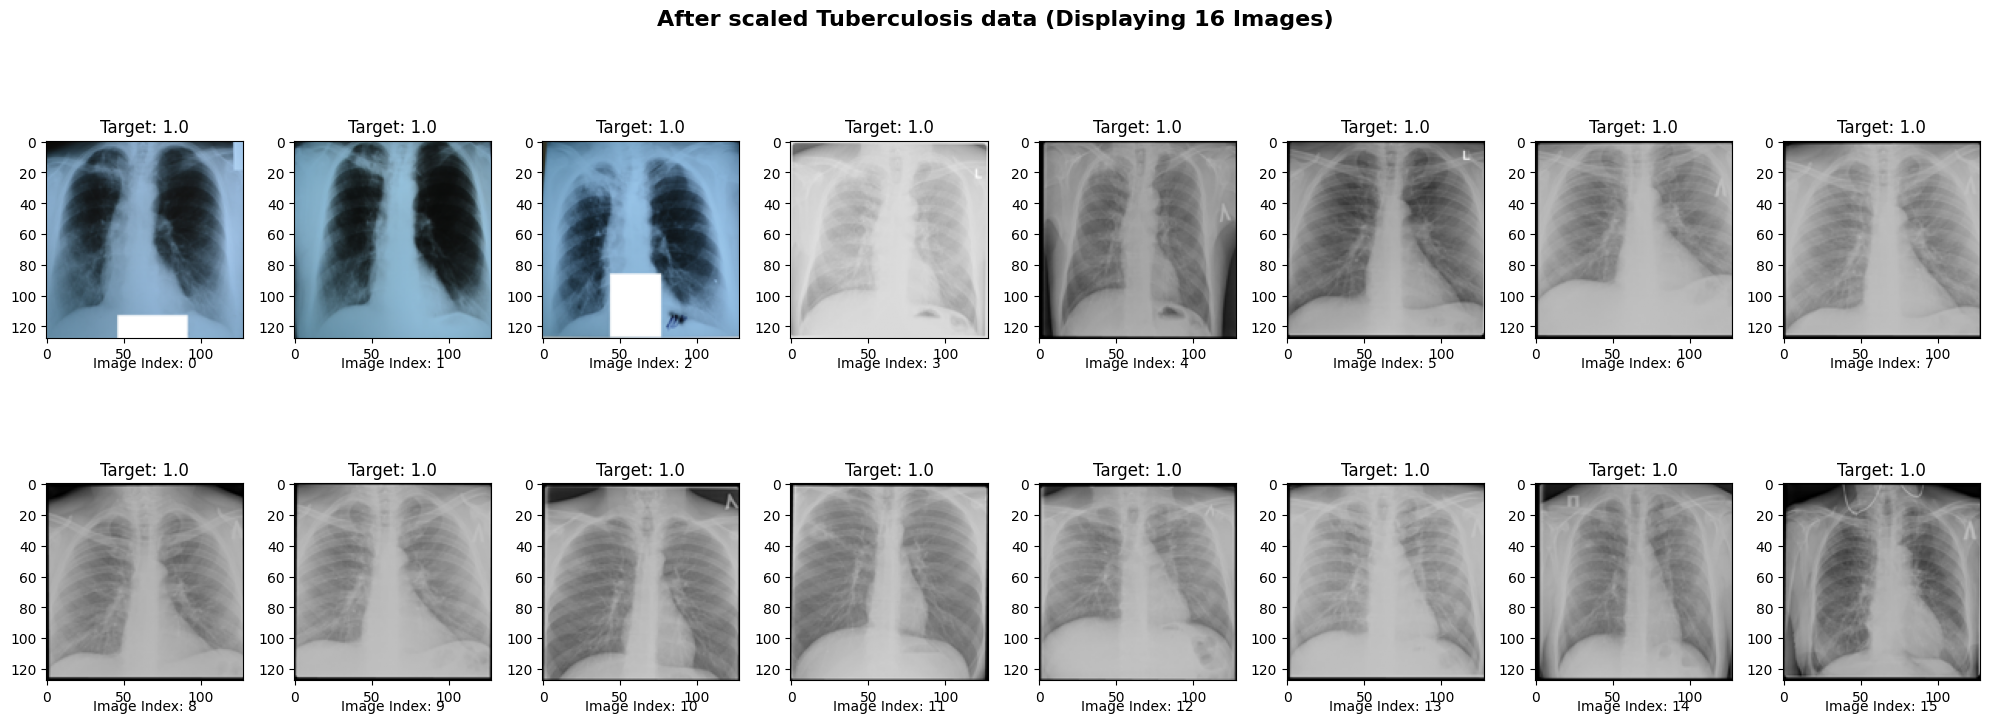

In [14]:
show_image(images=tb,
           target=target_tb,
           title='After scaled Tuberculosis data', 
           num_display=16, 
           num_cols=8, 
           cmap='gray', 
           random_mode=False)

In [15]:
tb_augmented = np.load("tb_augmented.npy")
target_tb_augmented = np.load("target_tb_augmented.npy")


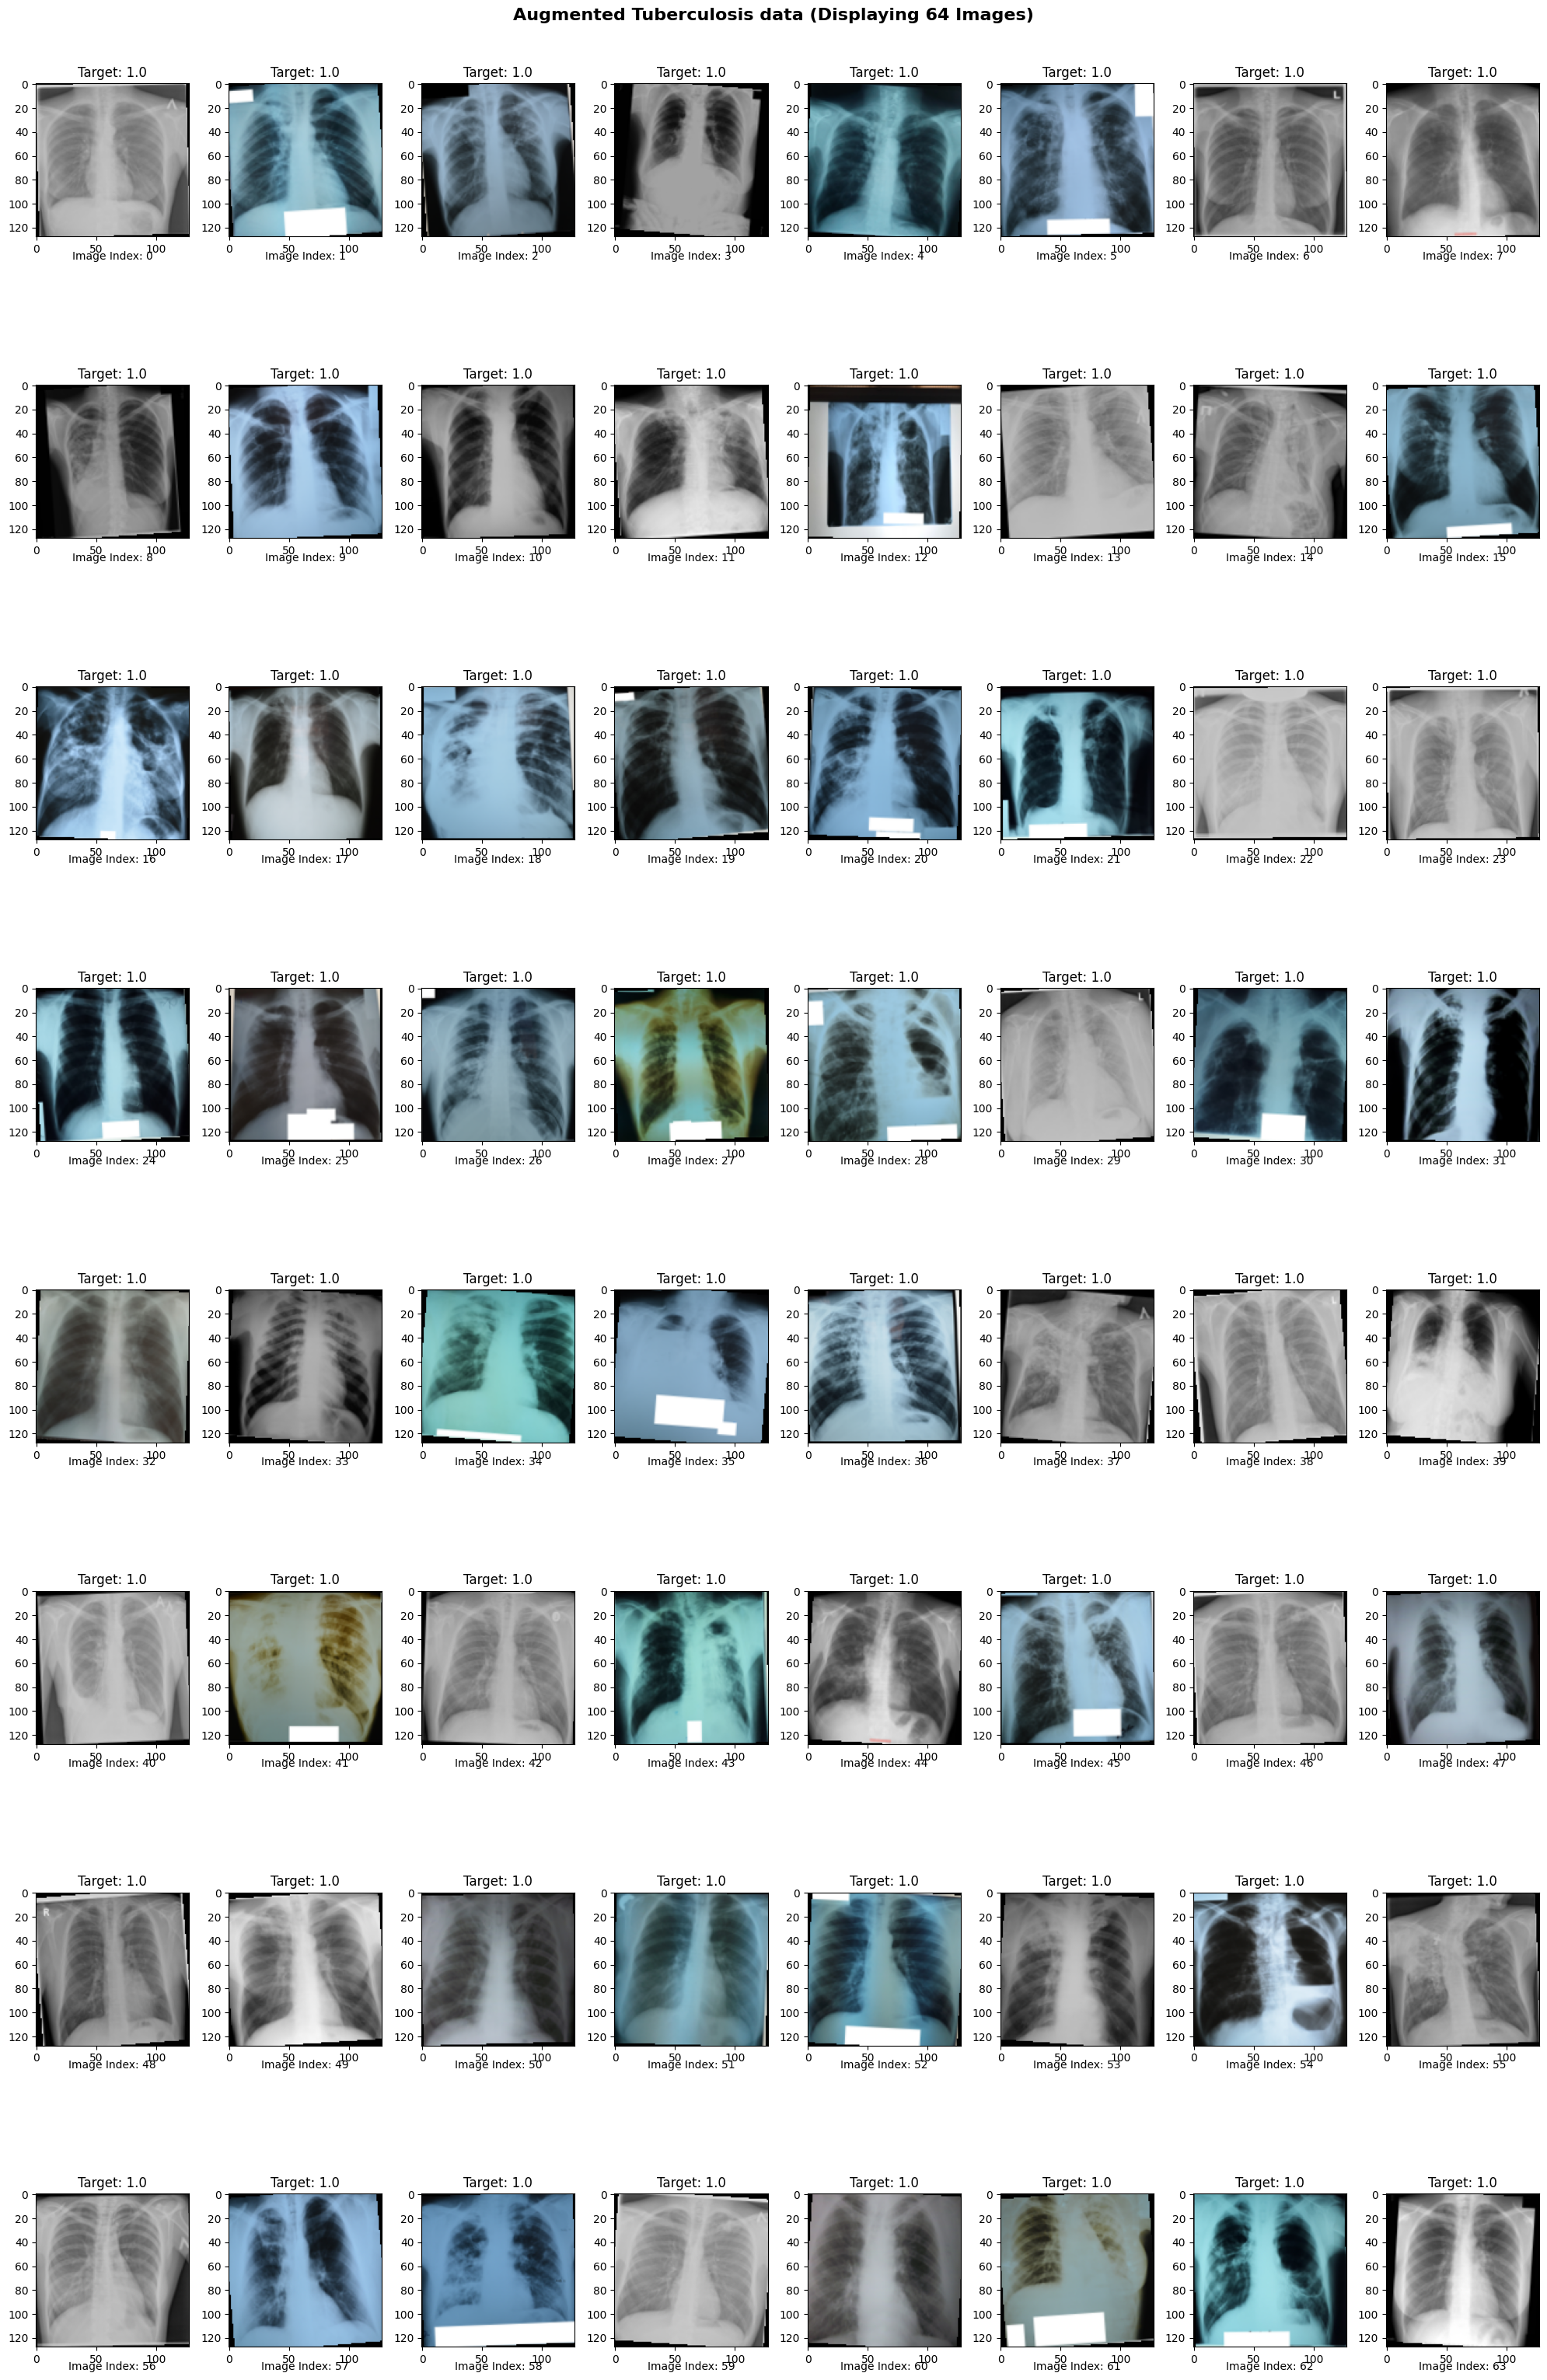

In [16]:
# Start index since 700 to last to observe to new training images
show_image(images=tb_augmented[700:-1],
           target=target_tb_augmented[700:-1],
           title='Augmented Tuberculosis data', 
           num_display=64, 
           num_cols=8, 
           cmap='gray', 
           random_mode=False)

In [17]:
from skimage.filters import threshold_otsu
from skimage.color import label2rgb
from skimage.morphology import closing, square
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border

In [20]:
class ImageSegmentation:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def lung_segmentation(self, X):
        if X.shape != self.input_shape:
            X = X[:, :, 0]

        # Equalize the image with CLAHE
        X = exposure.equalize_adapthist(
            X, kernel_size=None, clip_limit=0.01, nbins=256)

        # Create a binary threshold mask and apply it to the image
        thresh = threshold_otsu(image=X, nbins=256, hist=None)
        thresh = X > thresh
        bw = closing(X > thresh, square(1))

        # Clean up the borders
        cleared = clear_border(bw)

        # Label image regions
        label_image = label(cleared)
        image_label_overlay = label2rgb(
            label_image,
            image=X,
            bg_label=0,
            bg_color=(0, 0, 0))

        return image_label_overlay, label_image
    

    def show_segmented_images(self,images, target, title, num_display=16, num_cols=4, cmap='gray', random_mode=False,only_segmented=True):
        '''
        :Parameters
            images (ndarray (n,)): Input data as a numpy array.
            target (ndarray (n,)): Target data as a numpy array.
            title (String): Title of the plot.
            num_display (int): Number of images to display. Default is 16.
            num_cols (int): Number of columns in the plot. Default is 4.
            cmap (str): Color map for displaying images. Default is 'gray'.
            random_mode (bool): If True, display images randomly. If False, display the first num_display images. Default is False.
        '''
        # Determine the number of rows based on the num_cols parameter
        n_cols = min(num_cols, num_display)
        n_rows = int(np.ceil(num_display / n_cols))

        n_images = min(num_display, len(images))
        if random_mode:
            random_indices = np.random.choice(
                len(images), num_display, replace=False)
        else:
            random_indices = np.arange(num_display)

        fig, axes = plt.subplots(
            nrows=n_rows, ncols=n_cols, figsize=(20, 4*n_rows))
        for i, ax in enumerate(axes.flatten()):
            if i >= n_images:  # Check if the index exceeds the available number of images
                break
            # Incase (Did PCA)
            index = random_indices[i]
            if len(images.shape) == 2:
                image = images[index].reshape((128, 128)).astype(int)
            else:
                image = images[index]

            image_label_overlay, label_image = self.lung_segmentation(
                image)
                
            ax.imshow(
                label_image if only_segmented else image_label_overlay, cmap=cmap)
            ax.set_title("Target: {}".format(target[index]))

            # Add image index as text
            ax.text(0.5, -0.15, f'Image Index: {index}', transform=ax.transAxes,
                    fontsize=10, ha='center')

        plt.suptitle(f"{title} (Displaying {num_display} Images)",
                    fontsize=16, fontweight='bold')

        fig.set_facecolor('white')
        plt.tight_layout()  # Added to ensure proper spacing between subplots
        return plt.show()
    
    
    def show_segmented_image_from_path(self, image_path):
        # Load image from file path
        img = Image.open(image_path)

        # Preprocess the image (resize, convert to numpy array, etc.)
        img_array = np.array(img)  # Assuming img is a PIL Image
        # Additional preprocessing steps if needed...

        # Apply lung segmentation
        image_label_overlay, _ = self.lung_segmentation(img_array)

        # Display the segmented image
        plt.imshow(image_label_overlay, cmap='gray')
        plt.title("Lung Segmentation")
        plt.savefig("segmented Image")
        plt.show()

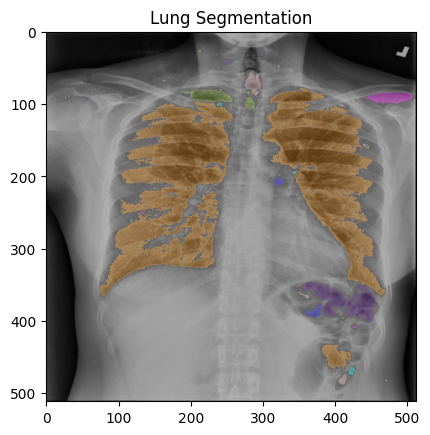

In [22]:
segmentation_model = ImageSegmentation(input_shape=(128, 128, 3))

# Provide the image path to get lung segmentation
lung_segmentation_result = segmentation_model.show_segmented_image_from_path(img_path)

# Display the segmented image


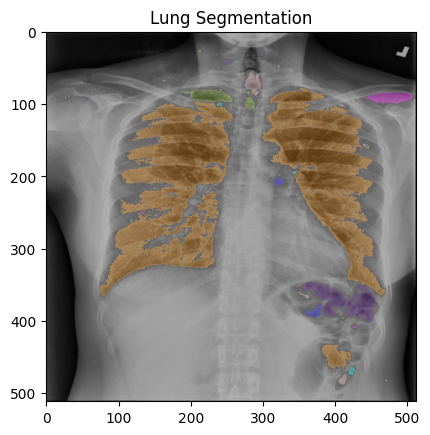

In [24]:
segmentation_model = ImageSegmentation(input_shape=(128, 128, 3))
seg_false=segmentation_model.show_segmented_image_from_path(img_path)
# seg_true=segmentation_model.lung_segmentation_from_path(img_path)

In [25]:

img_segmetator.show_segmented_images(images=X,
                                     title='Lung Segmentation',
                                     cmap='binary',
                                     random_mode=False,
                                     only_segmented=True)

NameError: name 'img_segmetator' is not defined

In [33]:
# Lime
import lime
from lime.lime_image import LimeImageExplainer, ImageExplanation
# Ski
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb
from skimage.transform import resize

import skimage.segmentation

# common
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import random

import cv2
import matplotlib.patches as mpatches
from skimage.filters import threshold_otsu
from skimage.exposure import equalize_adapthist
from skimage.color import label2rgb
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import square, closing
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel
from skimage.color import rgb2gray

class Explainer():
    def __init__(self, estimator, input_shape=None, threshold=None):
        self.estimator = estimator
        self.input_shape = input_shape

    def lime(self, X, y, top_labels, num_samples, num_features, class_names, num_display, method='slic', random_mode=False, cmap='gray'):
        '''
        Explain and visualize model predictions using LIME (Local Interpretable Model-Agnostic Explanations).

        Parameters:
            X (ndarray): Input data as a numpy array.
            y (ndarray): Target data as a numpy array.
            top_labels (int): Top coefficients to show (e.g., 1 for binary classification).
            num_samples (int): Number of perturbations to generate.
            num_features (int): Number of highlighted features (segmented areas) to extract.
            model (object): Trained machine learning model.
            class_names (list): List of class names.
            num_display (int): Number of images to display.
            random_mode (bool, optional): If True, display images randomly. Default is False.
            cmap (str, optional): Colormap for displaying images. Default is 'gray'.

        Returns:
            None

        This function explains and visualizes model predictions using LIME. It generates explanations for model predictions and displays them along with various image representations.

        Note:
        - The `X` input should have a shape like (num_images, width, height, channels) (e.g., (100, 128, 128, 1)).
        - The `class_names` list should contain class labels.
        - The function displays the explanations and does not return any values.
        '''

        # Model prediction
        
        y_hat = self.estimator.predict(X)
        prediction = (y_hat > 0.5).astype(int).flatten()

        n_cols = 5  # Display 5 images in each row

        title = r'$\bf{' + "Actual-Image" + '}$' + " vs " + \
            r'$\bf{' + "Model-Prediction" + '}$'

        n_images = min(num_display, len(X))

        if random_mode:
            random_indices = np.random.choice(
                len(X), num_display, replace=False)
        else:
            random_indices = np.arange(num_display)

        for i, idx in enumerate(random_indices):
            
            X_resized = tf.image.resize(X[idx], self.input_shape).numpy()
#             # Change to RBG for input in Lime
#             rgb_resized_image = cv2.cvtColor(X_resized, cv2.COLOR_GRAY2RGB)
            rgb_resized_image = X_resized
            explainer = LimeImageExplainer()

            def model_pred_fn(images):
                y_hat = self.estimator.predict(images)
                return y_hat
            
            def segment_fn(image):
                if method == 'felzenszwalb':
                    segments = felzenszwalb(image, scale=200, sigma=0.5, min_size=50)
                elif method == 'slic':
                    segments = slic(image, n_segments=50, compactness=10, sigma=1)
                elif method == 'quickshift':
                    segments = quickshift(image, kernel_size=2, max_dist=50, ratio=0.5)
                elif method == 'watershed':
                    gradient = sobel(rgb2gray(image))
                    segments = watershed(gradient, markers=50, compactness=0.001)
                elif method == 'lung_segmentation':
                    segments = self.lung_segmentation(image)
                else:
                    raise ValueError(
                        "Invalid segmentation method. Supported methods: 'felzenszwalb', 'slic', 'quickshift', 'watershed', 'lung_segmentation'")

                return segments

            explanation = explainer.explain_instance(
                rgb_resized_image,
                model_pred_fn,
                top_labels=top_labels,
                hide_color=0,
                num_samples=num_samples,
                segmentation_fn=segment_fn,
            )
            #  positive_only=True if prediction[idx] ==0  else False,
            temp, mask = explanation.get_image_and_mask(
                explanation.top_labels[0],
                positive_only=False,
                num_features=num_features,
                hide_rest=False,
                min_weight=0.0
                )

            # Create a figure with 1 row and 5 columns
            fig, axes = plt.subplots(1, n_cols, figsize=(30, 6))

            # Add a big header title above the subplots
            plt.suptitle(
                title, fontsize=16)

            # First axis: Actual Image
            axes[0].imshow(X_resized, cmap=cmap) 
            actual_title = r'$\bf{' + 'Actual' + '}$'
            actual_cls = class_names[int(y[idx])]

            model_title = r'$\bf{' + 'Model-Prediction' + '}$'
            model_cls = class_names[int(prediction[idx])]
            model_prob = '{:.9f}'.format(float(y_hat[idx]))
            axes[0].set_title(actual_title + '\nTarget: ' + actual_cls)

            image_label_overlay = label2rgb(
                segment_fn(rgb_resized_image),
                image=rgb_resized_image,
                bg_label=0,
                bg_color=(0, 0, 0))

            axes[1].imshow(X_resized, cmap=cmap)
            axes[1].imshow(image_label_overlay)

            axes[1].set_title(model_title + '\nTarget: ' + model_cls)

            axes[2].imshow(segment_fn(rgb_resized_image),cmap='binary')
            axes[2].set_title(
                r'$\bf{' + 'Segmentation' + '}$' + f'\nProbability: ' + model_prob)
            
            # Third axis: Explanation Image
            axes[3].imshow(mark_boundaries(
                rgb_resized_image, segment_fn(rgb_resized_image)))
            axes[3].set_title(
                r'$\bf{' + 'LIME-Explanation' + '}$' + f'\nnumber of segments: {len(np.unique(segment_fn(rgb_resized_image)))}')
            temp, mask = explanation.get_image_and_mask(
                0,
                positive_only=True if prediction[idx] == 0 else False,
                num_features=num_features,
                hide_rest=False,
                min_weight=0.0
            )
            # Third axis: Explanation Image
            axes[4].imshow(mark_boundaries(
                temp, mask))
            axes[4].set_title(
                r'$\bf{' + 'LIME-Explanation' + '}$' + f'\nPositive and Negative regions')

            # Add the image index text
            plt.text(0.5, -0.15, f'Image Index: {idx}', transform=axes[0].transAxes,
                     fontsize=10, ha='center')

            plt.tight_layout()
            plt.savefig('Lime_output.png', bbox_inches='tight')


            plt.show()

    def diff_sementation(self, X):
        # Generate a random sample index
        sample_index = random.randint(0, X.shape[0] - 1)

#         # Get the single grayscale sample
#         grayscale_sample = X[sample_index]

#         # Convert to RGB by repeating the single channel along the third axis
#         img = np.repeat(grayscale_sample, 3, axis=2)

        segments_fz = felzenszwalb(img, scale=200, sigma=0.5, min_size=50)
        segments_slic = slic(img, n_segments=50, compactness=10, sigma=1)
        segments_quick = quickshift(img, kernel_size=2, max_dist=50, ratio=0.5)
        gradient = sobel(rgb2gray(img))
        segments_watershed = watershed(gradient, markers=50, compactness=0.001)
        segments_equalize_adapthist = self.lung_segmentation(img)

        fig, ax = plt.subplots(1, 5, figsize=(30, 6))

        ax[0].imshow(mark_boundaries(img, segments_fz))
        ax[0].set_title("Felzenszwalbs's method")
        ax[0].text(
            0.5, -0.05, f"number of segments: {len(np.unique(segments_fz))}", transform=ax[0].transAxes, ha='center')

        ax[1].imshow(mark_boundaries(img, segments_slic))
        ax[1].set_title('SLIC')
        ax[1].text(
            0.5, -0.05, f"number of segments: {len(np.unique(segments_slic))}", transform=ax[1].transAxes, ha='center')

        ax[2].imshow(mark_boundaries(img, segments_quick))
        ax[2].set_title('Quickshift')
        ax[2].text(
            0.5, -0.05, f"number of segments: {len(np.unique(segments_quick))}", transform=ax[2].transAxes, ha='center')

        ax[3].imshow(mark_boundaries(img, segments_watershed))
        ax[3].set_title('Compact watershed')
        ax[3].text(
            0.5, -0.05, f"number of segments: {len(np.unique(segments_watershed))}", transform=ax[3].transAxes, ha='center')
        ax[4].imshow(mark_boundaries(img, segments_equalize_adapthist))
        ax[4].set_title('lung_segmentation')
        ax[4].text(
            0.5, -0.05, f"number of segments: {len(np.unique(segments_equalize_adapthist))}", transform=ax[4].transAxes, ha='center')

        for a in ax.ravel():
            a.set_axis_off()

        plt.tight_layout()
        plt.show()

    def lung_segmentation(self, X):
        # Single of exmaple
        X = X[:, :, 0]

        # Even out the contrast with CLAHE
        X_equalized = equalize_adapthist(
            X, kernel_size=None, clip_limit=0.05, nbins=256)

        # Make a binary threshold mask and apply it to the image
        thresh = threshold_otsu(image=X_equalized, nbins=256, hist=None)
        thresh = X_equalized > thresh
        bw = closing(X_equalized > thresh, square(1))

        # Clean up the borders
        cleared = clear_border(bw)

        # Label image regions
        label_image = label(cleared)
        

        return label_image


In [34]:
explnr = Explainer(estimator=model, input_shape=(128, 128))

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 1)       28        
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 1)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 3)         30        
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 32, 32, 3)         0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 6)         168       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 6)        

In [37]:
import cv2
import numpy as np
from skimage.transform import resize

def image_path_to_numpy(image_path):
    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Convert the image to RGB (OpenCV uses BGR by default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Normalize pixel values to be between 0 and 1
    image = image / 255.0

    return image

# Example usage:
image_paths = [img_path]

for image_path in image_paths:
    # Load and preprocess a single image
    image_array = image_path_to_numpy(image_path)

    # Resize the image to the expected input shape of your model
    target_shape = (128, 128, 3)
    resized_image = resize(image_array, target_shape, anti_aliasing=True)
    resized_image = np.expand_dims(resized_image, axis=0)  # Add batch dimension

    # Use the resized image in the LIME explanation
    explnr.lime(X=resized_image,
                y=[1.],  # Provide the target label for prediction
                top_labels=1,
                num_samples=1000,
                num_features=5,
                class_names=['Normal', 'Tuberculosis'],
                num_display=10,
                method='lung_segmentation',
                random_mode=True,
                cmap='gray'
                )


1/1 [==============================] - 0s 46ms/step


ValueError: Cannot take a larger sample than population when 'replace=False'

In [38]:
import cv2
import numpy as np
from skimage.transform import resize
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

def image_path_to_numpy(image_path):
    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Convert the image to RGB (OpenCV uses BGR by default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Normalize pixel values to be between 0 and 1
    image = image / 255.0

    return image

# Example usage:
image_paths = [img_path]

for image_path in image_paths:
    # Load and preprocess a single image
    image_array = image_path_to_numpy(image_path)

    # Resize the image to the expected input shape of your model
    target_shape = (128, 128, 3)
    resized_image = resize(image_array, target_shape, anti_aliasing=True)
    resized_image = np.expand_dims(resized_image, axis=0)  # Add batch dimension

    # Use the resized image in the LIME explanation
    # Use the resized image in the LIME explanation
    explnr.lime(X=resized_image,
            y=[1.],  # Provide the target label for prediction
            top_labels=1,
            num_samples=1000,
            num_features=5,
            class_names=['Normal', 'Tuberculosis'],
            num_display=1,
            method='lung_segmentation',
            random_mode=True,
            cmap='gray',
            save_to_folder='/path/to/explanation_folder'

            )



TypeError: Explainer.lime() got an unexpected keyword argument 'save_to_folder'

1/1 [==============================] - 0s 59ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 122ms/step


  1%|          | 10/1000 [00:00<00:22, 44.68it/s]

1/1 [==============================] - 0s 62ms/step


  2%|▏         | 20/1000 [00:00<00:18, 54.04it/s]

1/1 [==============================] - 0s 91ms/step


  3%|▎         | 30/1000 [00:00<00:19, 50.93it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 40/1000 [00:00<00:16, 58.15it/s]

1/1 [==============================] - 0s 77ms/step


  5%|▌         | 50/1000 [00:00<00:18, 51.81it/s]

1/1 [==============================] - 0s 52ms/step


  6%|▌         | 60/1000 [00:01<00:16, 57.69it/s]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 70/1000 [00:01<00:16, 56.38it/s]

1/1 [==============================] - 0s 76ms/step


  8%|▊         | 80/1000 [00:01<00:17, 54.04it/s]

1/1 [==============================] - 0s 57ms/step


  9%|▉         | 90/1000 [00:01<00:17, 53.24it/s]

1/1 [==============================] - 0s 59ms/step


 10%|█         | 100/1000 [00:01<00:16, 53.84it/s]

1/1 [==============================] - 0s 88ms/step


 11%|█         | 110/1000 [00:02<00:17, 50.88it/s]

1/1 [==============================] - 0s 67ms/step


 12%|█▏        | 120/1000 [00:02<00:17, 50.53it/s]

1/1 [==============================] - 0s 61ms/step


 13%|█▎        | 130/1000 [00:02<00:17, 50.57it/s]

1/1 [==============================] - 0s 53ms/step


 14%|█▍        | 140/1000 [00:02<00:16, 53.17it/s]

1/1 [==============================] - 0s 52ms/step


 15%|█▌        | 150/1000 [00:02<00:15, 53.71it/s]

1/1 [==============================] - 0s 53ms/step


 16%|█▌        | 160/1000 [00:02<00:15, 54.90it/s]

1/1 [==============================] - 0s 69ms/step


 17%|█▋        | 170/1000 [00:03<00:15, 52.61it/s]

1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 180/1000 [00:03<00:15, 53.92it/s]

1/1 [==============================] - 0s 55ms/step


 19%|█▉        | 190/1000 [00:03<00:14, 54.68it/s]

1/1 [==============================] - 0s 47ms/step


 20%|██        | 200/1000 [00:03<00:13, 59.96it/s]

1/1 [==============================] - 0s 52ms/step


 21%|██        | 210/1000 [00:03<00:13, 60.18it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 220/1000 [00:03<00:12, 64.76it/s]

1/1 [==============================] - 0s 76ms/step


 23%|██▎       | 230/1000 [00:04<00:12, 59.69it/s]

1/1 [==============================] - 0s 59ms/step


 24%|██▍       | 240/1000 [00:04<00:13, 56.82it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 250/1000 [00:04<00:13, 57.01it/s]

1/1 [==============================] - 0s 90ms/step


 26%|██▌       | 260/1000 [00:04<00:13, 53.36it/s]

1/1 [==============================] - 0s 82ms/step


 27%|██▋       | 270/1000 [00:05<00:15, 48.33it/s]

1/1 [==============================] - 0s 58ms/step


 28%|██▊       | 280/1000 [00:05<00:14, 48.40it/s]

1/1 [==============================] - 0s 67ms/step


 29%|██▉       | 290/1000 [00:05<00:15, 46.14it/s]

1/1 [==============================] - 0s 67ms/step


 30%|███       | 300/1000 [00:05<00:15, 46.35it/s]

1/1 [==============================] - 0s 62ms/step


 31%|███       | 310/1000 [00:05<00:14, 48.66it/s]

1/1 [==============================] - 0s 78ms/step


 32%|███▏      | 320/1000 [00:06<00:13, 50.87it/s]

1/1 [==============================] - 0s 67ms/step


 33%|███▎      | 330/1000 [00:06<00:13, 48.69it/s]

1/1 [==============================] - 0s 52ms/step


 34%|███▍      | 340/1000 [00:06<00:13, 50.66it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 350/1000 [00:06<00:11, 55.23it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 360/1000 [00:06<00:10, 62.48it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 370/1000 [00:06<00:09, 63.97it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 380/1000 [00:06<00:08, 70.36it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 390/1000 [00:07<00:07, 77.06it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 400/1000 [00:07<00:07, 80.94it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 410/1000 [00:07<00:07, 74.39it/s]

1/1 [==============================] - 0s 63ms/step


 42%|████▏     | 420/1000 [00:07<00:08, 67.86it/s]

1/1 [==============================] - 0s 81ms/step


 43%|████▎     | 430/1000 [00:07<00:09, 58.25it/s]

1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 440/1000 [00:07<00:10, 54.81it/s]

1/1 [==============================] - 0s 78ms/step


 45%|████▌     | 450/1000 [00:08<00:10, 51.89it/s]

1/1 [==============================] - 0s 64ms/step


 46%|████▌     | 460/1000 [00:08<00:10, 52.37it/s]

1/1 [==============================] - 0s 80ms/step


 47%|████▋     | 470/1000 [00:08<00:09, 54.51it/s]

1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 480/1000 [00:08<00:09, 52.07it/s]

1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 490/1000 [00:08<00:09, 52.61it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 500/1000 [00:09<00:08, 58.20it/s]

1/1 [==============================] - 0s 50ms/step


 51%|█████     | 510/1000 [00:09<00:07, 64.25it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 520/1000 [00:09<00:07, 68.19it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 530/1000 [00:09<00:06, 74.88it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 540/1000 [00:09<00:06, 72.69it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▌    | 550/1000 [00:09<00:06, 69.58it/s]

1/1 [==============================] - 0s 67ms/step


 56%|█████▌    | 560/1000 [00:09<00:06, 63.77it/s]

1/1 [==============================] - 0s 77ms/step


 57%|█████▋    | 570/1000 [00:10<00:07, 59.08it/s]

1/1 [==============================] - 0s 63ms/step


 58%|█████▊    | 580/1000 [00:10<00:07, 55.46it/s]

1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 590/1000 [00:10<00:07, 53.62it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 600/1000 [00:10<00:06, 60.67it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 610/1000 [00:10<00:05, 65.29it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 620/1000 [00:10<00:05, 64.80it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 630/1000 [00:10<00:05, 71.76it/s]

1/1 [==============================] - 0s 84ms/step


 64%|██████▍   | 640/1000 [00:11<00:05, 63.35it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▌   | 650/1000 [00:11<00:05, 59.18it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 660/1000 [00:11<00:05, 60.18it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 670/1000 [00:11<00:05, 58.50it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 680/1000 [00:11<00:05, 58.18it/s]

1/1 [==============================] - 0s 65ms/step


 69%|██████▉   | 690/1000 [00:12<00:05, 56.32it/s]

1/1 [==============================] - 0s 87ms/step


 70%|███████   | 700/1000 [00:12<00:05, 53.40it/s]

1/1 [==============================] - 0s 66ms/step


 71%|███████   | 710/1000 [00:12<00:05, 50.72it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 720/1000 [00:12<00:04, 56.92it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 730/1000 [00:12<00:04, 60.50it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 740/1000 [00:12<00:04, 63.54it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 750/1000 [00:13<00:03, 67.42it/s]

1/1 [==============================] - 0s 82ms/step


 76%|███████▌  | 760/1000 [00:13<00:03, 61.36it/s]

1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 770/1000 [00:13<00:04, 56.25it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 780/1000 [00:13<00:03, 56.66it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 790/1000 [00:13<00:03, 59.50it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 800/1000 [00:13<00:03, 65.53it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████  | 810/1000 [00:14<00:03, 62.53it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 820/1000 [00:14<00:03, 59.41it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 830/1000 [00:14<00:02, 65.12it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 840/1000 [00:14<00:02, 72.45it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 850/1000 [00:14<00:01, 78.75it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 860/1000 [00:14<00:01, 80.32it/s]

1/1 [==============================] - 0s 79ms/step


 87%|████████▋ | 870/1000 [00:14<00:01, 69.46it/s]

1/1 [==============================] - 0s 66ms/step


 88%|████████▊ | 880/1000 [00:15<00:02, 59.18it/s]

1/1 [==============================] - 0s 63ms/step


 89%|████████▉ | 890/1000 [00:15<00:01, 56.96it/s]

1/1 [==============================] - 0s 62ms/step


 90%|█████████ | 900/1000 [00:15<00:01, 55.39it/s]

1/1 [==============================] - 0s 74ms/step


 91%|█████████ | 910/1000 [00:15<00:01, 55.02it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 920/1000 [00:15<00:01, 52.23it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 930/1000 [00:16<00:01, 53.79it/s]

1/1 [==============================] - 0s 88ms/step


 94%|█████████▍| 940/1000 [00:16<00:01, 51.98it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 950/1000 [00:16<00:00, 52.92it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 960/1000 [00:16<00:00, 55.84it/s]

1/1 [==============================] - 0s 78ms/step


 97%|█████████▋| 970/1000 [00:16<00:00, 57.19it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 980/1000 [00:16<00:00, 62.52it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 990/1000 [00:17<00:00, 64.92it/s]

1/1 [==============================] - 0s 74ms/step


100%|██████████| 1000/1000 [00:17<00:00, 58.01it/s]
C:\Users\prasa\AppData\Local\Temp\ipykernel_6872\2985811535.py:181: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


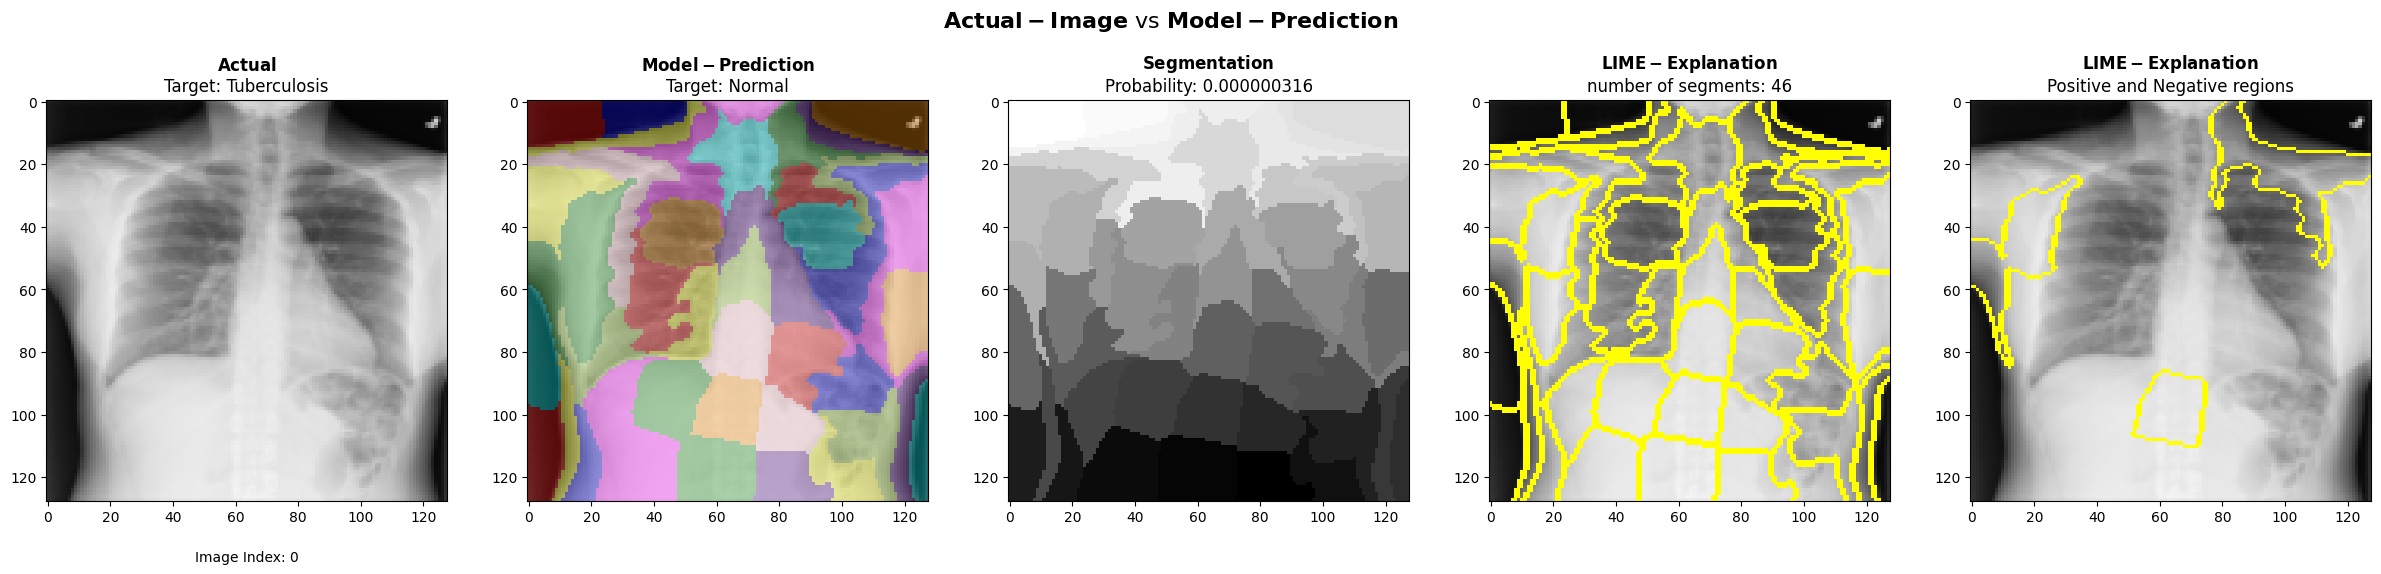

None


In [27]:
import os

explanations = explnr.lime(X=resized_image,
                           y=[1.],  # Provide the target label for prediction
                           top_labels=1,
                           num_samples=1000,
                           num_features=5,
                           class_names=['Normal', 'Tuberculosis'],
                           num_display=1,
                           method='slic',
                           random_mode=True,
                           cmap='gray'
                           )

print(explanations)

# Save each explanation individually



In [172]:
len(explanations)
output_folder = 'C:\\Users\\prasa\\Desktop\\FYP\\explantions'
os.makedirs(output_folder, exist_ok=True)

for i, explanation in enumerate(explanations):
    output_path = os.path.join(output_folder, f'explanation_{i}.png')
    explanation.save_to_file(output_path)

TypeError: object of type 'NoneType' has no len()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 10/1000 [00:00<00:11, 83.39it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 20/1000 [00:00<00:12, 76.63it/s]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 30/1000 [00:00<00:12, 77.62it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 40/1000 [00:00<00:11, 82.96it/s]

1/1 [==============================] - 0s 59ms/step


  5%|▌         | 50/1000 [00:00<00:12, 77.55it/s]

1/1 [==============================] - 0s 65ms/step


  6%|▌         | 60/1000 [00:00<00:15, 61.60it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 70/1000 [00:00<00:13, 67.80it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 80/1000 [00:01<00:12, 73.50it/s]

1/1 [==============================] - 0s 49ms/step


  9%|▉         | 90/1000 [00:01<00:11, 76.85it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 100/1000 [00:01<00:11, 79.49it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█         | 110/1000 [00:01<00:10, 81.80it/s]

1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 120/1000 [00:01<00:12, 68.69it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 130/1000 [00:01<00:12, 68.72it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 140/1000 [00:01<00:12, 70.16it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 150/1000 [00:02<00:11, 71.38it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 160/1000 [00:02<00:11, 74.21it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 170/1000 [00:02<00:11, 74.31it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 180/1000 [00:02<00:11, 73.52it/s]

1/1 [==============================] - 0s 68ms/step


 19%|█▉        | 190/1000 [00:02<00:11, 69.94it/s]

1/1 [==============================] - 0s 49ms/step


 20%|██        | 200/1000 [00:02<00:11, 66.76it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 210/1000 [00:02<00:10, 73.05it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 220/1000 [00:02<00:09, 79.15it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 230/1000 [00:03<00:09, 82.95it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 240/1000 [00:03<00:08, 87.41it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 255/1000 [00:03<00:07, 104.44it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 266/1000 [00:03<00:07, 103.95it/s]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 280/1000 [00:03<00:08, 82.49it/s] 

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 290/1000 [00:03<00:08, 82.91it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 300/1000 [00:03<00:08, 86.75it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 310/1000 [00:03<00:07, 89.29it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 324/1000 [00:04<00:06, 102.59it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 337/1000 [00:04<00:06, 110.02it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 350/1000 [00:04<00:07, 91.36it/s] 

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 361/1000 [00:04<00:06, 93.75it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 372/1000 [00:04<00:06, 94.97it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 382/1000 [00:04<00:06, 95.33it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 392/1000 [00:04<00:06, 94.55it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 402/1000 [00:04<00:06, 91.79it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 412/1000 [00:05<00:06, 91.84it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 422/1000 [00:05<00:06, 92.35it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 432/1000 [00:05<00:06, 92.86it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 447/1000 [00:05<00:05, 108.76it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 460/1000 [00:05<00:05, 90.99it/s] 

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 474/1000 [00:05<00:05, 102.85it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 486/1000 [00:05<00:05, 94.40it/s] 

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 500/1000 [00:05<00:05, 87.02it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████▏    | 514/1000 [00:06<00:04, 98.88it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▎    | 525/1000 [00:06<00:04, 101.45it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 540/1000 [00:06<00:04, 92.94it/s] 

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 550/1000 [00:06<00:04, 93.01it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 566/1000 [00:06<00:03, 109.28it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 580/1000 [00:06<00:04, 95.20it/s] 

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 595/1000 [00:06<00:03, 107.65it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 610/1000 [00:07<00:04, 96.88it/s] 

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 621/1000 [00:07<00:03, 99.28it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 633/1000 [00:07<00:03, 104.11it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 645/1000 [00:07<00:03, 107.89it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 660/1000 [00:07<00:03, 97.45it/s] 

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 672/1000 [00:07<00:03, 102.80it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 683/1000 [00:07<00:03, 104.24it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 694/1000 [00:07<00:02, 105.31it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 705/1000 [00:07<00:03, 92.22it/s] 

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 715/1000 [00:08<00:03, 93.63it/s]

1/1 [==============================] - 0s 61ms/step


 72%|███████▎  | 725/1000 [00:08<00:03, 84.41it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 734/1000 [00:08<00:03, 78.02it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 750/1000 [00:08<00:03, 81.94it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 760/1000 [00:08<00:02, 83.42it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 770/1000 [00:08<00:02, 82.89it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 780/1000 [00:08<00:02, 81.68it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 797/1000 [00:09<00:01, 103.42it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 808/1000 [00:09<00:01, 101.59it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 819/1000 [00:09<00:01, 98.81it/s] 

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 830/1000 [00:09<00:02, 81.74it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 840/1000 [00:09<00:01, 83.83it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 850/1000 [00:09<00:01, 85.42it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 860/1000 [00:09<00:01, 83.89it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 870/1000 [00:09<00:01, 75.82it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 883/1000 [00:10<00:01, 88.63it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 893/1000 [00:10<00:01, 87.08it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 903/1000 [00:10<00:01, 87.18it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 920/1000 [00:10<00:00, 85.45it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 930/1000 [00:10<00:00, 85.45it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 940/1000 [00:10<00:00, 83.73it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 950/1000 [00:10<00:00, 84.92it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 960/1000 [00:10<00:00, 88.08it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 980/1000 [00:11<00:00, 92.93it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 990/1000 [00:11<00:00, 90.49it/s]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 1000/1000 [00:11<00:00, 87.86it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


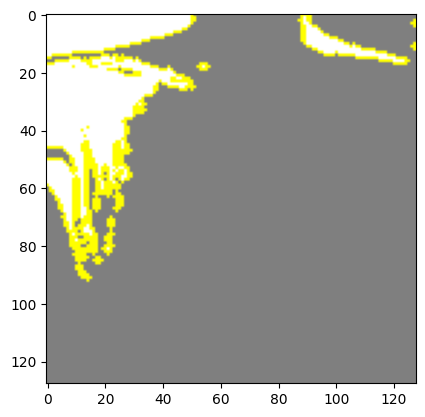

In [145]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Create a LIME explainer
explainer = lime_image.LimeImageExplainer()

# Load an example image for explanation
img_path =img_path
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)

# Define the prediction function
def predict_fn(images):
    # Assuming you have a model called 'model' defined elsewhere
    return model.predict(images)

# Explain the prediction
explanation = explainer.explain_instance(img_array, predict_fn, top_labels=1, hide_color=0.0, num_samples=1000)

# Display the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
img_boundry1 = mark_boundaries(temp / 2 + 0.5, mask)

plt.imshow(img_boundry1, cmap='gray')
plt.show()


In [28]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from PIL import Image
import io

# Function to add an image to the PDF
def add_image(pdf_canvas, image_path, x, y, width, height):
    pdf_canvas.drawInlineImage(image_path, x, y, width, height)

# Function to generate the PDF report
def generate_pdf_report(model, image_path, lime_image_path, lung_segmentation_path, output_path='report.pdf'):
    # Create a PDF canvas
    pdf_canvas = canvas.Canvas(output_path, pagesize=letter)

    # Load and preprocess the image for classification
    # Replace this with your actual image preprocessing code
    image = preprocess_image(image_path)

    # Get the classification result from the model
    classification_result = model.predict(image)

    # Add classification information
    pdf_canvas.drawString(100, 750, f'Classification: {classification_result}')

    # Add Lime explanation image
    add_image(pdf_canvas, lime_image_path, 100, 500, 400, 200)

    # Add Lung Segmentation image
    add_image(pdf_canvas, lung_segmentation_path, 100, 250, 400, 200)

    # Save the PDF
    pdf_canvas.save()

# Example usage
# Replace "path_to_your_image.jpg" with the actual path to your image
image_path = img_path
lime_image_path = img_path  # Replace with the path to your Lime explanation image
lung_segmentation_path = img_path
# Replace "model" with your actual model instanceimg
# Make sure your model has a `predict` method that takes an image and returns the classification result
# You may need to adjust the image preprocessing based on your model requirements
 # Replace with your model loading code

generate_pdf_report(model, image_path, lime_image_path, lung_segmentation_path)


NameError: name 'preprocess_image' is not defined